<a href="https://colab.research.google.com/github/duruamobi/AAI2026/blob/main/Coding_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import zipfile
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ---------------------------------------------------------
# Data Source:
# King County House Sales Dataset (Seattle area)
# Kaggle: https://www.kaggle.com/datasets/harlfoxem/housesalesprediction
# File used: kc_house_data.csv (downloaded from Kaggle)
# ---------------------------------------------------------

# Path to your uploaded zip - Corrected path
zip_path = Path("/content/kc_house_data.csv.zip")

# Unzip into /mnt/data and find the CSV inside
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("/mnt/data")
    csv_names = [n for n in z.namelist() if n.lower().endswith(".csv")]
    if not csv_names:
        raise FileNotFoundError("No CSV found inside the ZIP file.")
    csv_path = Path("/mnt/data") / csv_names[0]

# Load real dataset
df = pd.read_csv(csv_path)

# Keep only required columns for Part 1
df = df[['price', 'sqft_living', 'zipcode']]

# Rename columns to match your original example
df = df.rename(columns={
    'sqft_living': 'square_footage',
    'zipcode': 'location'
})

# Features and target
X = df[['square_footage', 'location']]
y = df['price']

# Preprocessing: One-hot encode zipcode (location)
preprocessor = ColumnTransformer(
    transformers=[
        ('location', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['location'])
    ],
    remainder='passthrough'
)

# Create pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split + train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model.fit(X_train, y_train)

# Example prediction: 2000 sqft in zipcode 98178
new_house = pd.DataFrame({'square_footage': [2000], 'location': [98178]})
predicted_price = model.predict(new_house)
print(f"Predicted price for a 2000 sq ft house in zipcode 98178: ${predicted_price[0]:,.2f}")

# Print $/sqft effect
sqft_coef = model.named_steps['regressor'].coef_[-1]
print(f"\nOn average, price increases by ${sqft_coef:.2f} per square foot (holding zipcode constant).")


Predicted price for a 2000 sq ft house in zipcode 98178: $384,476.81

On average, price increases by $250.93 per square foot (holding zipcode constant).


In [ ]:
import pandas as pd
import zipfile
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ---------------------------------------------------------
# Data Source (Kaggle):
# Downloaded from Kaggle (search on Kaggle: "customer churn dataset")
# File in this project: customer_churn_dataset-testing-master.csv
# (Replace the comment above with your exact Kaggle dataset link if required by your instructor.)
# ---------------------------------------------------------

# Load real dataset from your uploaded ZIP
zip_path = Path("/content/customer_churn_dataset-testing-master.csv.zip") # Corrected path

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("/mnt/data")
    csv_names = [n for n in z.namelist() if n.lower().endswith(".csv")]
    if not csv_names:
        raise FileNotFoundError("No CSV found inside the ZIP file.")
    csv_path = Path("/mnt/data") / csv_names[0]

df = pd.read_csv(csv_path)

# ---- Select features that match Part 2 requirements ----
# Demographics: Age, Gender
# Usage patterns: Usage Frequency, Tenure
# Purchase history: Total Spend
# Customer service: Support Calls
# Target: Churn (0/1)
required_cols = [
    "Age", "Gender", "Tenure", "Usage Frequency",
    "Support Calls", "Total Spend", "Churn"
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in dataset: {missing}")

X = df[["Age", "Gender", "Tenure", "Usage Frequency", "Support Calls", "Total Spend"]]
y = df["Churn"]

# Preprocessing: scale numeric + one-hot encode categoricals
num_features = ["Age", "Tenure", "Usage Frequency", "Support Calls", "Total Spend"]
cat_features = ["Gender"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat_features),
    ]
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=2000, random_state=42))
])

# Split + train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
model.fit(X_train, y_train)

# Predict churn probability for a new customer (example)
new_customer = pd.DataFrame({
    "Age": [35],
    "Gender": ["Male"],          # must be a value used in your dataset (e.g., Male/Female)
    "Tenure": [12],              # months (example)
    "Usage Frequency": [20],     # frequency score (example)
    "Support Calls": [5],
    "Total Spend": [1500],       # total spend (example)
})

churn_probability = model.predict_proba(new_customer)[0][1]  # P(churn=1)

threshold = 0.5
churn_prediction = 1 if churn_probability > threshold else 0

print(f"Churn Probability for new customer: {churn_probability:.2f}")
print(f"Churn Prediction (1 = churn, 0 = no churn): {churn_prediction}")

# Display model coefficients (log-odds)
cat_feature_names = (
    model.named_steps["preprocessor"]
         .named_transformers_["cat"]
         .get_feature_names_out(cat_features)
         .tolist()
)

feature_names = num_features + cat_feature_names
coefficients = model.named_steps["classifier"].coef_[0]

print("\nModel Coefficients (log-odds):")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")


Churn Probability for new customer: 0.10
Churn Prediction (1 = churn, 0 = no churn): 0

Model Coefficients (log-odds):
Age: 0.1511
Tenure: 0.4499
Usage Frequency: -0.2780
Support Calls: 0.7140
Total Spend: -0.1998
Gender_Female: 0.3838
Gender_Male: -0.4952


In [ ]:
import pandas as pd
import zipfile
from pathlib import Path

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Data Source (Kaggle):
# Downloaded from Kaggle (search: "customer churn dataset")
# File used here: customer_churn_dataset-testing-master.csv
# ---------------------------------------------------------

# Load real dataset from your uploaded ZIP
zip_path = Path("/content/customer_churn_dataset-testing-master.csv.zip")

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("/mnt/data")
    csv_names = [n for n in z.namelist() if n.lower().endswith(".csv")]
    if not csv_names:
        raise FileNotFoundError("No CSV found inside the ZIP file.")
    csv_path = Path("/mnt/data") / csv_names[0]

df = pd.read_csv(csv_path)

# ---- Choose features for segmentation (NO churn label needed) ----
# Demographics: Age
# Buying/Spend: Total Spend
# Behavior: Usage Frequency, Tenure
# Customer service interactions: Support Calls
features = ["Age", "Total Spend", "Usage Frequency", "Tenure", "Support Calls"]

missing = [c for c in features if c not in df.columns]
if missing:
    raise ValueError(f"Missing required feature columns in dataset: {missing}")

# Drop missing values in selected features (simple cleanup)
df_seg = df.dropna(subset=features).copy()

X = df_seg[features]

# Scale features (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- Determine optimal number of clusters using elbow method ----
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(list(K), inertia, 'bo-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.savefig("elbow_plot.png")
plt.close()

# ---- Apply K-Means with chosen K ----
# (You can change this after looking at elbow_plot.png)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_seg["cluster"] = kmeans.fit_predict(X_scaled)

# ---- Analyze clusters ----
cluster_summary = df_seg.groupby("cluster")[features].mean().round(2)
print("Cluster Characteristics (Mean Values):")
print(cluster_summary)

# Example targeted strategies (simple rule-based interpretation)
for cluster in range(optimal_k):
    print(f"\nCluster {cluster} Strategy:")

    avg_spend = cluster_summary.loc[cluster, "Total Spend"]
    avg_usage = cluster_summary.loc[cluster, "Usage Frequency"]
    avg_support = cluster_summary.loc[cluster, "Support Calls"]
    avg_tenure = cluster_summary.loc[cluster, "Tenure"]

    if avg_spend >= cluster_summary["Total Spend"].quantile(0.66):
        print("High-spending customers: Offer VIP perks, exclusive promotions, loyalty rewards.")
    elif avg_support >= cluster_summary["Support Calls"].quantile(0.66):
        print("High-support-need customers: Improve support experience, proactive check-ins, service credits.")
    elif avg_tenure <= cluster_summary["Tenure"].quantile(0.33):
        print("Newer customers: Focus on onboarding, education, early retention offers.")
    elif avg_usage >= cluster_summary["Usage Frequency"].quantile(0.66):
        print("Highly engaged customers: Upsell premium plans, bundles, referrals program.")
    else:
        print("Moderate customers: Personalized offers based on interests and usage.")

# Save cluster assignments
df_seg.to_csv("customer_segments.csv", index=False)
print("\nSaved: elbow_plot.png and customer_segments.csv")


Cluster Characteristics (Mean Values):
           Age  Total Spend  Usage Frequency  Tenure  Support Calls
cluster                                                            
0        41.29       518.90            15.63   27.70           1.83
1        44.13       553.20             6.94   32.85           7.09
2        40.41       550.66            23.03   35.45           7.24

Cluster 0 Strategy:
Newer customers: Focus on onboarding, education, early retention offers.

Cluster 1 Strategy:
High-spending customers: Offer VIP perks, exclusive promotions, loyalty rewards.

Cluster 2 Strategy:
High-support-need customers: Improve support experience, proactive check-ins, service credits.

Saved: elbow_plot.png and customer_segments.csv



6-Month Demand Forecast (Total Sales Volume):
   month  predicted_demand
0     51      2.244066e+08
1     52      2.243901e+08
2     53      2.243736e+08
3     54      2.243571e+08
4     55      2.243406e+08
5     56      2.243241e+08


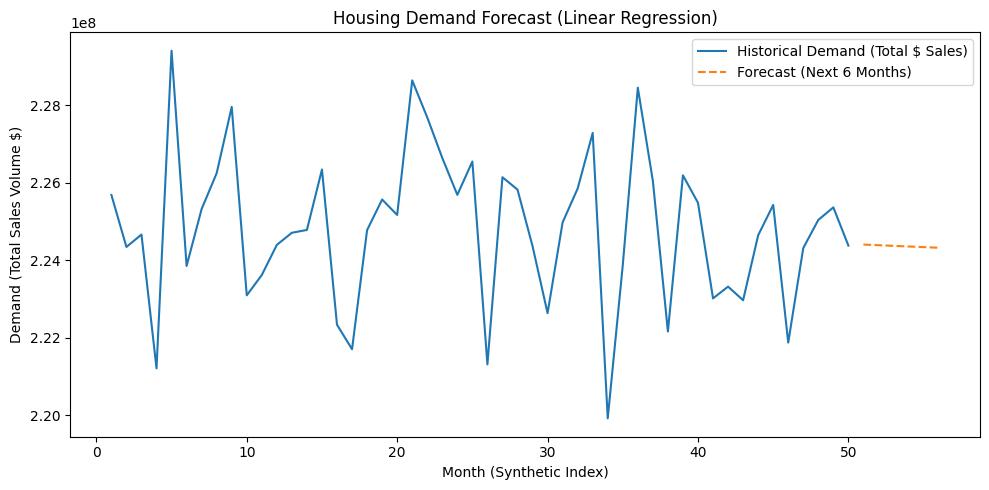

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import zipfile

# Load dataset from your uploaded zip
ZIP_PATH = "/content/housing_price_dataset.csv.zip"
CSV_NAME = "housing_price_dataset.csv"

with zipfile.ZipFile(ZIP_PATH) as z:
    with z.open(CSV_NAME) as f:
        df = pd.read_csv(f)

df = df.dropna()

# Create synthetic months (no true date column in this dataset)
SALES_PER_MONTH = 1000
df["month"] = (df.index // SALES_PER_MONTH) + 1

# Demand proxy: total sales volume per month (varies!)
monthly = df.groupby("month")["Price"].sum().reset_index(name="demand")

# Train regression
X = monthly[["month"]]
y = monthly["demand"]

model = LinearRegression()
model.fit(X, y)

# Predict next 6 months
last_month = int(monthly["month"].max())
future_months = pd.DataFrame({"month": range(last_month + 1, last_month + 7)})
predictions = model.predict(future_months)

# Print forecast
forecast = future_months.copy()
forecast["predicted_demand"] = predictions
print("\n6-Month Demand Forecast (Total Sales Volume):")
print(forecast)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly["month"], y, label="Historical Demand (Total $ Sales)")
plt.plot(future_months["month"], predictions, label="Forecast (Next 6 Months)", linestyle="--")
plt.xlabel("Month (Synthetic Index)")
plt.ylabel("Demand (Total Sales Volume $)")
plt.title("Housing Demand Forecast (Linear Regression)")
plt.legend()
plt.tight_layout()
plt.show()

**Assumptions**

- Each row in the dataset represents a completed home sale.

- The dataset does not include a true date or month column, so months are approximated by grouping every fixed number of sales (SALES_PER_MONTH) into a synthetic month.

- Housing demand is represented by total monthly sales volume (sum of prices) rather than number of transactions.

- The relationship between time (month index) and demand follows a linear trend.

- Past patterns in total sales volume will continue into the next six months.

**Challenges**

- The dataset lacks real timestamps, so the monthly grouping is artificial and may not reflect true market cycles.

- Linear Regression assumes a linear relationship and cannot capture:

   - Seasonality (spring/summer buying trends),

   - Economic shocks,

   - Interest rate changes,

   - Sudden inventory fluctuations.

- Total sales volume can increase due to higher home prices rather than increased buyer demand.

- The model does not account for external economic indicators that strongly influence housing demand.

**Potential Improvements**

- Use a dataset that includes actual sale dates and aggregate demand by real calendar months.

- Incorporate additional predictive features such as:

   - Mortgage interest rates,

   - Inventory levels,

   - Days on market,

   - Regional economic indicators.

- Apply more advanced forecasting models such as:

   - Polynomial Regression,

   - Random Forest Regression,

   - ARIMA or Prophet for time-series forecasting.

- Split historical data into training and testing sets and evaluate model performance using metrics such as MAE or RMSE.

- Include confidence intervals to quantify uncertainty in the 6-month forecast.